## Setup

In [49]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg
import bargaining_algorithm as ba
from figures import *
from checks import *

import numpy as np
import numba as nb
import scipy.optimize as optimize
import copy

from EconModel import EconModelClass
from consav.grids import nonlinspace
from consav import linear_interp, linear_interp_1d
from consav import quadrature

#plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})

# c++ settings
do_cpp = True
do_compile = True
threads = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Compile C++ files

In [50]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

### Model settings

In [51]:
# settings for models to solve
T = 10
do_load = True
do_save = True

specs = {
       'py baseline':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     }
              },
    
       'cpp intraperiod_consumption':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'cpp_intraperiod_consumption': True,
                     }
              },
              
       'cpp value_of_choice_couple':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'cpp_intraperiod_consumption': True,
                     'cpp_value_of_choice_couple':True,
                     }
              },
              
       'cpp solve_remain_couple':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':False,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     'cpp_intraperiod_consumption': True,
                     'cpp_value_of_choice_couple':True,
                     'cpp_solve_remain_couple': True,
                     }
              },
              
       'cpp':    
              {'latexname':'', 
              'load': do_load,
              'save': do_save,
              'par':{'T':T,
                     'do_cpp':True,
                     'threads':threads,
                     
                     'div_A_share':0.3,
                     'sigma_love':0.0,
                     }
              },
}

In [52]:
def printer(specs):
    # find the longest name in specs
    max_length = 0
    for key in specs.keys():
        if len(key)>max_length:
            max_length = len(key)
            
    # get all keys in par dictionaries
    all_keys = set()
    for spec in specs.values():
        all_keys |= set(spec['par'].keys())
            
    # print header with model names
    print(f"{' '*max_length}|",end='')
    for name in specs.keys():
        print(f"{name.center(max_length)}|",end='')
    print('')
    print('-'*(max_length+1)*(len(specs.keys())+1))
        
    for p in all_keys:
        print(f"{p.ljust(max_length)}|",end='')
        for name in specs.keys():
            if p in specs[name]['par'].keys(): # use value from specs
                par_value = specs[name]['par'][p]
            else: # use default value
                par_value = getattr(model.par,p)
            
            print(f"{str(par_value).center(max_length)}|",end='')
        print('')

In [53]:
printer(specs)

                           |        py baseline        |cpp intraperiod_consumption| cpp value_of_choice_couple|  cpp solve_remain_couple  |            cpp            |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
cpp_value_of_choice_couple |           False           |           False           |            True           |            True           |           False           |
div_A_share                |            0.3            |            0.3            |            0.3            |            0.3            |            0.3            |
T                          |             10            |             10            |             10            |             10            |             10            |
cpp_solve_remain_couple    |           False           |           False           |           False           |            True           |           Fals

Setup model1

In [54]:
# solve different models
models = {}
for name,spec in specs.items():
        #unpack
        par = spec['par']
        do_load = spec['load']
        do_save = spec['save']
        
        if do_load:
            print(f'loading {name}...')
        else:
            print(f'solving {name}...')
        
        
        # setup model
        models[name] = brg.HouseholdModelClass(name=name, par=spec['par'], load=do_load)
        models[name].link_to_cpp(force_compile=False)
        models[name].spec = spec
        
        # solve
        if not do_load:
            models[name].solve()
        
        # save model
        if do_save:
            models[name].save()
            
        # delink
        models[name].cpp.delink()

loading py baseline...
loading cpp intraperiod_consumption...
loading cpp value_of_choice_couple...
loading cpp solve_remain_couple...
loading cpp...


## Plots

User settings

In [55]:
# Choose models
model_names  = list(models.keys())

# Get model values
model_values = [models[name] for name in model_names]

# Choose index
t  = 0
iP = 0
iL = 0
iA = 0
idx = (t,iP,iL,iA)

Bargaining

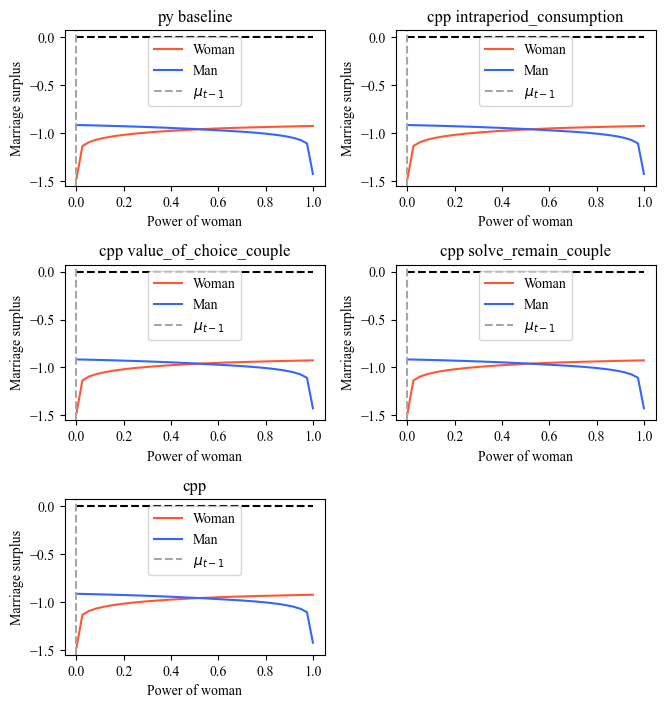

In [56]:
model_plot(model_values,plot_surplus,t,iP,iL,iA, subtitles=model_names)

## Focus on 2 models

In [57]:
model1 = models['py baseline']
model2 = models['cpp intraperiod_consumption']

Absolute differences

In [58]:
sol_max_abs_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=False)
print_namespace(sol_max_abs_diff)

Vw_single: 0.0
Vm_single: 0.0
Cw_priv_single: 0.0
Cm_priv_single: 0.0
Cw_pub_single: 0.0
Cm_pub_single: 0.0
Cw_tot_single: 0.0
Cm_tot_single: 0.0
Vw_trans_single: 0.0
Vm_trans_single: 0.0
Cw_priv_trans_single: 0.0
Cm_priv_trans_single: 0.0
Cw_pub_trans_single: 0.0
Cm_pub_trans_single: 0.0
Cw_tot_trans_single: 0.0
Cm_tot_trans_single: 0.0
Vw_couple: 0.00024020501615279032
Vm_couple: 0.00024020426379161121
Cw_priv_couple: 0.020160294305747617
Cm_priv_couple: 0.02377597664663611
C_pub_couple: 0.034074091402404694
C_tot_couple: 0.06284378303162708
Vw_remain_couple: 0.0012230947063858189
Vm_remain_couple: 0.0014772443588091377
Cw_priv_remain_couple: 0.027740519857332835
Cm_priv_remain_couple: 0.02377597664663611
C_pub_remain_couple: 0.034074091402404694
C_tot_remain_couple: 0.06284378303162708
power_idx: 1
power: 0.0007746645333392976
savings_vec: 1.783586727199804e-06
Vw_plus_vec: 7.38753120899105e-08
Vm_plus_vec: 0.0002191444980008117
marg_V_couple: 0.0
marg_V_remain_couple: 0.0
EmargU_pd

Relative differences

In [59]:
sol_max_rel_diff = difference_in_namespace(model1.sol, model2.sol, output='max_abs_value', relative=True)
print_namespace(sol_max_rel_diff)

Vw_single: 0.0
Vm_single: 0.0
Cw_priv_single: 0.0
Cm_priv_single: 0.0
Cw_pub_single: 0.0
Cm_pub_single: 0.0
Cw_tot_single: 0.0
Cm_tot_single: 0.0
Vw_trans_single: 0.0
Vm_trans_single: 0.0
Cw_priv_trans_single: 0.0
Cm_priv_trans_single: 0.0
Cw_pub_trans_single: 0.0
Cm_pub_trans_single: 0.0
Cw_tot_trans_single: 0.0
Cm_tot_trans_single: 0.0
Vw_couple: 1.090801601046182
Vm_couple: 1.0907965475025774
Cw_priv_couple: 0.0960904325213222
Cm_priv_couple: 0.5308370548974428
C_pub_couple: 0.024392657682031717
C_tot_couple: 0.024392777196630404
Vw_remain_couple: 1.090801601046182
Vm_remain_couple: 1.0907965475025774
Cw_priv_remain_couple: 0.024579824402972784
Cm_priv_remain_couple: 0.024579668990529664
C_pub_remain_couple: 0.024392657682031717
C_tot_remain_couple: 0.024392777196630404
power_idx: 0.058823529411764705
power: 0.09593873912206088
savings_vec: 3.9067805955054707e-07
Vw_plus_vec: 1.7544312611953136e-08
Vm_plus_vec: 0.0005450064390767908
marg_V_couple: nan
marg_V_remain_couple: nan
Emarg

c:\Users\zbk883\OneDrive - University of Copenhagen\Documents\projects\household_guide\HouseholdBargainingGuide\checks.py:51: RuntimeWarning: invalid value encountered in divide
  diff = np.where(var1 == 0, np.nan, (var1 - var2)/var1)
c:\Users\zbk883\OneDrive - University of Copenhagen\Documents\projects\household_guide\HouseholdBargainingGuide\checks.py:71: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(np.abs(variable))


In [60]:
sol_max_rel_diff_index = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)
print_namespace(sol_max_rel_diff_index)

Vw_single: (0, 0)
Vm_single: (0, 0)
Cw_priv_single: (0, 0)
Cm_priv_single: (0, 0)
Cw_pub_single: (0, 0)
Cm_pub_single: (0, 0)
Cw_tot_single: (0, 0)
Cm_tot_single: (0, 0)
Vw_trans_single: (0, 0)
Vm_trans_single: (0, 0)
Cw_priv_trans_single: (0, 0)
Cm_priv_trans_single: (0, 0)
Cw_pub_trans_single: (0, 0)
Cm_pub_trans_single: (0, 0)
Cw_tot_trans_single: (0, 0)
Cm_tot_trans_single: (0, 0)
Vw_couple: (0, 0, 39, 49)
Vm_couple: (0, 20, 39, 49)
Cw_priv_couple: (1, 12, 20, 49)
Cm_priv_couple: (1, 6, 20, 49)
C_pub_couple: (1, 10, 20, 49)
C_tot_couple: (1, 6, 20, 49)
Vw_remain_couple: (3, 1, 21, 12)
Vm_remain_couple: (4, 16, 1, 21)
Cw_priv_remain_couple: (1, 18, 20, 49)
Cm_priv_remain_couple: (1, 6, 20, 49)
C_pub_remain_couple: (1, 10, 20, 49)
C_tot_remain_couple: (1, 6, 20, 49)
power_idx: (0, 17, 21, 3)
power: (0, 14, 20, 20)
savings_vec: (0,)
Vw_plus_vec: (0,)
Vm_plus_vec: (0,)
marg_V_couple: (0, 0, 0, 0)
marg_V_remain_couple: (0, 0, 0, 0)
EmargU_pd: (0, 0, 0)
C_tot_pd: (0, 0, 0)
M_pd: (0, 0, 0

## Plot the differences

Specify the variable that index of maximum absolute difference should be based on

In [61]:
variable = 'Vw_couple'

Find index with largest difference

In [62]:
sol_max_abs_diff_idx = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)

In [63]:
idx = getattr(sol_max_abs_diff_idx,variable)

(t,iP,iL,iA) = idx
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

t = 0, iP = 0, iL = 39, iA = 49


### Bargaining power

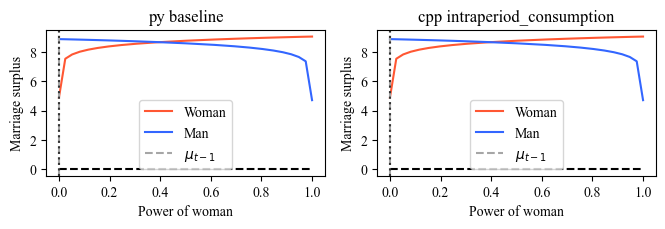

In [64]:
model_plot([model1,model2],plot_surplus,t,iP,iL,iA, subtitles=[model1.name,model2.name])

### Values

Plot female values

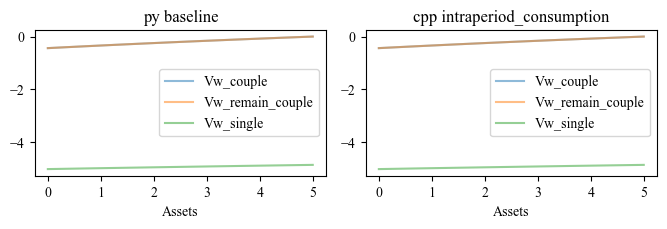

In [65]:
model_plot([model1,model2], plot_var_over_assets, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

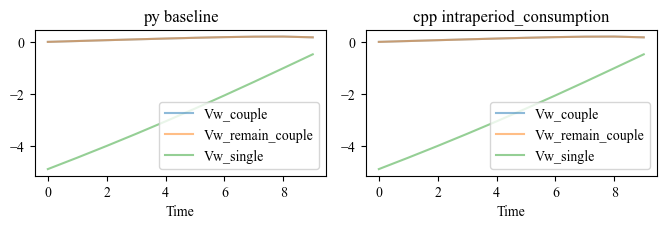

In [66]:
model_plot([model1,model2], plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, subtitles=[model1.name, model2.name ])

Plot male values

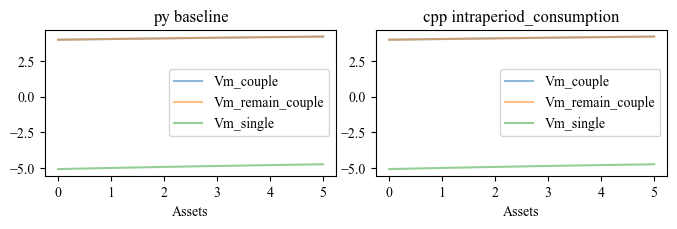

In [67]:
model_plot([model1,model2], plot_var_over_assets, ['Vm_couple','Vm_remain_couple','Vm_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

### Consumption

Plot female consumption

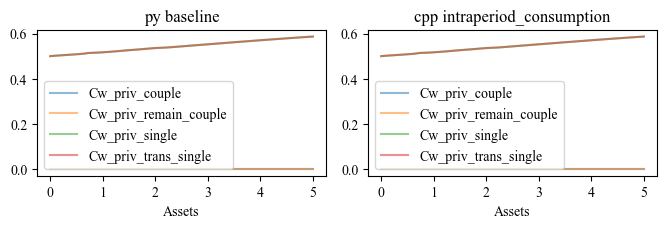

In [68]:
model_plot([model1,model2], plot_var_over_assets, ['Cw_priv_couple','Cw_priv_remain_couple','Cw_priv_single', 'Cw_priv_trans_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

Plot male consumption

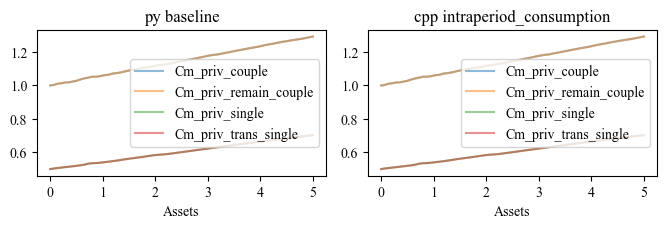

In [69]:
model_plot([model1,model2], plot_var_over_assets, ['Cm_priv_couple','Cm_priv_remain_couple','Cm_priv_single', 'Cm_priv_trans_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

Plot public consumption

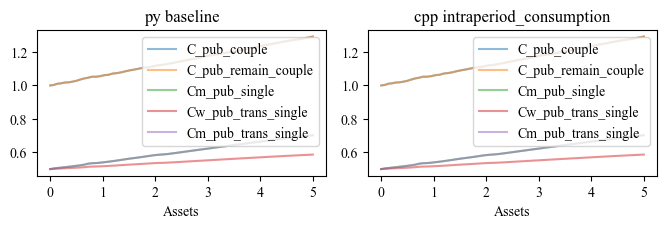

In [70]:
model_plot([model1,model2], plot_var_over_assets, ['C_pub_couple','C_pub_remain_couple','Cm_pub_single', 'Cw_pub_trans_single', 'Cm_pub_trans_single'], idx, grid_points=False, subtitles=[model1.name, model2.name ])

## Plots of difference

In [71]:
model_diff =  brg.HouseholdModelClass(name='Model differences')
model_diff.par = model1.par
model_diff.sol = difference_in_namespace(model1.sol, model2.sol)

Plot value

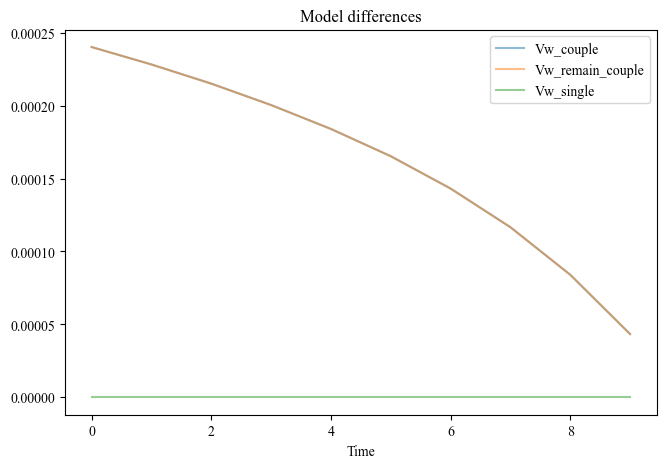

In [72]:
model_plot([model_diff], plot_var_over_time, ['Vw_couple','Vw_remain_couple','Vw_single'], idx, subtitles=[model_diff.name])

Plot consumption

Text(0.5, 0.5, 'Ctot')

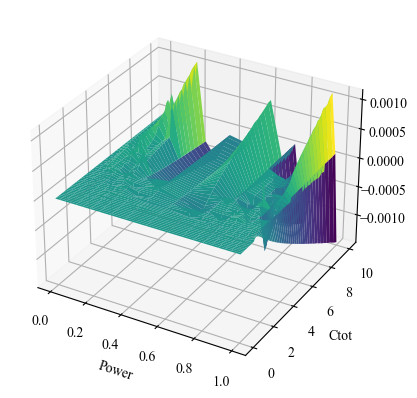

In [73]:
# plot pre_Ctot_Cw_priv in a 3 dimensional plot with using meshgrids 
fig = plt.figure()
ax = plt.axes(projection='3d')
mesh1, mesh2 = np.meshgrid(model1.par.grid_power, model1.par.grid_Ctot, indexing='ij')

ax.plot_surface(mesh1,mesh2, model_diff.sol.pre_Ctot_Cw_priv, cmap='viridis', edgecolor='none')

# label axes
ax.set_xlabel('Power')
ax.set_ylabel('Ctot')


## PY to CPP decoposition

In [83]:
model_bank = {}
model_bank[1] = models['py baseline']
model_bank[2] = models['cpp intraperiod_consumption']
model_bank[3] = models['cpp value_of_choice_couple']
model_bank[4] = models['cpp solve_remain_couple']
model_bank[5] = models['cpp']

output = ''
relative = False

var = 'Vw_remain_couple'
relevent_vars = ['Vw_couple','Vw_remain_couple','Vw_single']

Find index with largest difference

In [87]:

sol_max_abs_diff_idx = difference_in_namespace(model1.sol, model2.sol, output='max_abs_index', relative=False)
idx = getattr(sol_max_abs_diff_idx,var)

(t,iP,iL,iA) = idx
print(f't = {t}, iP = {iP}, iL = {iL}, iA = {iA}')

t = 3, iP = 1, iL = 21, iA = 12


Calculate accumulated differences

In [88]:
diff = {}
diff_accumulated = {}
model_diff = brg.HouseholdModelClass(name=f'PY to CPP decomposition')

diff_accumulated[0] = np.zeros(getattr(model_bank[1].sol,var).shape)
for v in relevent_vars:
    setattr(model_diff.sol,f'{v}_{0}',np.zeros(getattr(model_bank[1].sol,v).shape))

for i in range(1,5):
    diff[i]             = difference_in_namespace(model_bank[i].sol, model_bank[i+1].sol, output=output, relative=relative)
    for v in relevent_vars:
        setattr(model_diff.sol,f'{v}_{i}',getattr(model_diff.sol,f'{v}_{i-1}') + getattr(diff[i],v))

Plot decomposition 

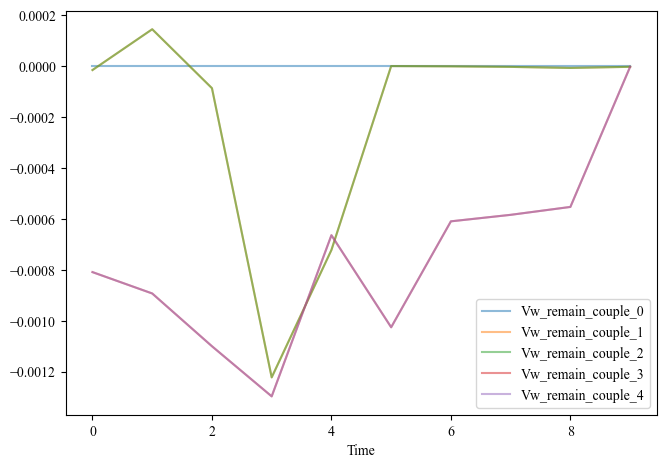

In [89]:
plot_vars = {}
for relevent_var in relevent_vars:
    plot_vars[relevent_var] = [f'{relevent_var}_{i}' for i in range(5)]

model_plot(model_diff, plot_var_over_time, plot_vars[var], idx, subtitles=None)